# Final Project

In [8]:
# 移除不必要的警告
import warnings
warnings.filterwarnings('ignore')

### 獲取歷史資料

In [9]:
from ml_finlab.data import Data

data = Data()

rev = data.get("當月營收")

close = data.get_adj("收盤價")
open_ = data.get_adj("開盤價")
high = data.get_adj("最高價")
low = data.get_adj("最低價")
vol = data.get("成交股數")

PB = data.get("股價淨值比")
pe = data.get("本益比")
DY = data.get("殖利率(%)")

rev.index = rev.index.shift(5, "d")

### 計算features

In [10]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

#####上為原版資料###
def yoy(n):
    denominator = rev.shift(12 + n)
    result = rev.shift(n) / denominator - 1
    result[denominator < 0] = 0  # 如果分母为负，将对应的结果设置为0
    return result

def delta_yoy(n):
    yoy_current = yoy(n)
    yoy_previous = yoy(n + 1)
    delta = yoy_current - yoy_previous
    return delta

def willr(n):
    highest_high = high.rolling(n, min_periods=1).max()
    lowest_low = low.rolling(n, min_periods=1).min()
    willr = (highest_high - close) / (highest_high - lowest_low) * -100
    return willr

def linearreg_slope(n):
    slope = (close - close.shift(n)) / n
    return slope

def adx(n):
    true_range = high - low
    true_range = true_range.fillna(0)
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    plus_dm = plus_dm.rolling(n).sum()
    minus_dm = minus_dm.abs().rolling(n).sum()
    
    tr_sum = true_range.rolling(n).sum()
    tr_sum[tr_sum == 0] = 0.0001
    
    plus_di = (plus_dm / tr_sum) * 100
    minus_di = (minus_dm / tr_sum) * 100
    
    dx = ((plus_di - minus_di).abs() / (plus_di + minus_di).abs()) * 100
    adx = dx.rolling(n).mean()
    
    return adx


def adxr(n):
    adx_value = adx(n)  # 先計算ADX值
    adxr = adx_value.rolling(n).mean()  # 計算ADX值的平均值
    return adxr

def rsi(n):
    diff = close.diff()
    up = diff.where(diff > 0, 0)
    down = -diff.where(diff < 0, 0)
    avg_gain = up.rolling(n).mean()
    avg_loss = down.rolling(n).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def kd(n):
    l = close.rolling(n).min()
    h = close.rolling(n).max()
    rsv = (close - l) / (h - l)
    k = rsv.rolling(3).mean()
    d = k.rolling(3).mean()
    return k - d


#---------

def ma_ratio(n):
    ma_short = close.rolling(n).mean()
    ma_long = close.rolling(2 * n).mean()
    return ma_short / ma_long

def volume_change(n):
    return vol.pct_change(n)

def range_ratio(n):
    range_high = high.rolling(n).max()
    range_low = low.rolling(n).min()
    return (range_high - range_low) / range_low


In [11]:
features = {
    'mom{}'.format(n): mom(n) for n in range(1, 10)
}

features.update({
    'bias_{}'.format(n): bias(n) for n in [5, 60, 120, 240]
})

features.update({
    'PB': PB,
    'PE': pe,
    'DY': DY
})


features.update({
    'acc_{}'.format(n): acc(n) for n in [5, 10, 20, 60, 120, 240]
})

features.update({
    'rsv_{}'.format(n): rsv(n) for n in [60, 120, 240]
})

####上為原版資料###
features.update({
    'yoy_{}'.format(n): yoy(n) for n in range(0, 0)
})
features.update({
    'delta_yoy_{}'.format(n): delta_yoy(n) for n in range(0, 2)
})

features.update({
    'willr_{}'.format(n): willr(n) for n in [14, 20, 60]
})

features.update({
    'linearreg_slope_{}'.format(n): linearreg_slope(n) for n in [14, 112, 224]
})

#features.update({
#    f'kd_{n}': kd(n) for n in [ 9, 14, 20, 60]
#})
#
features.update({
    'adxr_{}'.format(n): adxr(n) for n in [14, 20, 30]
})

#features.update({
#    'ma_ratio_{}'.format(n): ma_ratio(n) for n in [20, 40, 60]
#})
#
features.update({
    'volume_change_{}'.format(n): volume_change(n) for n in [20, 40, 60, 120]
})

#features.update({
#    'range_ratio_{}'.format(n): range_ratio(n) for n in [10, 30, 60]
#})
#

In [12]:
#import pandas as pd
#t1 = pd.read_pickle("history/items/bargin_report/外陸資買賣超股數(不含外資自營商).pkl")
#t2 = pd.read_pickle("history/items/bargin_report/投信買賣超股數.pkl")
#t3 = pd.read_pickle("history/items/bargin_report/自營商買賣超股數(自行買賣).pkl")

### 製作dataset

##### 設定買賣頻率

In [13]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-12-15', '2023-01-15', '2023-02-15', '2023-03-15',
               '2023-04-15', '2023-05-15', '2023-06-15', '2023-07-15',
               '2023-08-15', '2023-09-15'],
              dtype='datetime64[ns]', name='date', length=224, freq=None)

##### 將dataframe 組裝起來

In [14]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [15]:

for name, f in features.items():
    features[name] = f.unstack()

In [16]:
import pandas as pd
dataset = pd.DataFrame(features)

In [17]:
##我要把金融股拿掉 所以把28開頭全去掉
#dataset = dataset[~dataset.index.get_level_values('stock_id').str.startswith('28')]

In [18]:
feature_names = list(dataset.columns)
feature_names

['mom1',
 'mom2',
 'mom3',
 'mom4',
 'mom5',
 'mom6',
 'mom7',
 'mom8',
 'mom9',
 'bias_5',
 'bias_60',
 'bias_120',
 'bias_240',
 'PB',
 'PE',
 'DY',
 'acc_5',
 'acc_10',
 'acc_20',
 'acc_60',
 'acc_120',
 'acc_240',
 'rsv_60',
 'rsv_120',
 'rsv_240',
 'delta_yoy_0',
 'delta_yoy_1',
 'willr_14',
 'willr_20',
 'willr_60',
 'linearreg_slope_14',
 'linearreg_slope_112',
 'linearreg_slope_224',
 'adxr_14',
 'adxr_20',
 'adxr_30',
 'volume_change_20',
 'volume_change_40',
 'volume_change_60',
 'volume_change_120']

In [21]:
from ml_finlab import ml

vol=data.get('成交股數')/1000
vol_ma5=vol.rolling(20).mean()

股本 = data.get('股本合計').reindex(close.index, method='ffill')
市值 = 股本 * close / 10 * 1000

In [22]:
ml.add_feature(dataset, 'vol_ma5', vol_ma5)

ml.add_feature(dataset, '市值', 市值)

### 新增 label

In [23]:
from ml_finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

### 刪除太大太小的歷史資料

In [24]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset,
                                              feature_names, thresh=0.01)

print(dataset_drop_extreme_case.shape)

(463680, 44)
(370599, 44)


In [25]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [26]:
dataset_drop_extreme_case.index.get_level_values("date")

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-12-15', '2023-01-15', '2023-02-15', '2023-03-15',
               '2023-04-15', '2023-05-15', '2023-06-15', '2023-07-15',
               '2023-08-15', '2023-09-15'],
              dtype='datetime64[ns]', name='date', length=370599, freq=None)

In [27]:
dataset_drop_extreme_case.dropna(how='any')

mom1      mom2      mom3      mom4      mom5  \
stock_id date                                                           
1101     2013-12-15  1.058951  1.022962  0.995874  1.037642  0.997260   
         2014-01-15  1.051343  1.058951  1.022962  0.995874  1.037642   
         2014-04-15  0.621104  0.858543  1.019245  1.051343  1.058951   
         2014-05-15  1.779752  0.621104  0.858543  1.019245  1.051343   
         2014-06-15  1.067093  1.779752  0.621104  0.858543  1.019245   
...                       ...       ...       ...       ...       ...   
9962     2023-04-15  1.110722  0.729045  1.249495  1.004024  1.163303   
         2023-05-15  1.020832  1.110722  0.729045  1.249495  1.004024   
         2023-06-15  0.759387  1.020832  1.110722  0.729045  1.249495   
         2023-07-15  1.250776  0.759387  1.020832  1.110722  0.729045   
         2023-08-15  0.834370  1.250776  0.759387  1.020832  1.110722   

                         mom6      mom7      mom8      mom9    bias_5  ...  \
stock_id date                                                          ...   
1101     2013-12-15  0.962146  1.048773  1.707108  0.606532  1.009235  ...   
         2014-01-15  0.997260  0.962146  1.048773  1.707108  1.020059  ...   
         2014-04-15  1.022962  0.995874  1.037642  0.997260  0.996306  ...   
         2014-05-15  1.058951  1.022962  0.995874  1.037642  1.015240  ...   
         2014-06-15  1.051343  1.058951  1.022962  0.995874  0.981186  ...   
...                       ...       ...       ...       ...       ...  ...   
9962     2023-04-15  0.830797  1.280940  0.641536  1.694666  0.998378  ...   
         2023-05-15  1.163303  0.830797  1.280940  0.641536  0.989011  ...   
         2023-06-15  1.004024  1.163303  0.830797  1.280940  1.001999  ...   
         2023-07-15  1.249495  1.004024  1.163303  0.830797  0.993485  ...   
         2023-08-15  0.729045  1.249495  1.004024  1.163303  0.989043  ...   

                       adxr_20    adxr_30  volume_change_20  volume_change_40  \
stock_id date                                                                   
1101     2013-12-15  29.761857  24.731269         -0.217160          0.567855   
         2014-01-15  30.076809  25.356298          1.476814         -0.108915   
         2014-04-15  22.794304  15.486479          1.622022         -0.213251   
         2014-05-15  25.878172  21.654924          0.195934          1.398132   
         2014-06-15  36.761805  20.640856         -0.172702         -0.010606   
...                        ...        ...               ...               ...   
9962     2023-04-15  33.700434  42.617742          4.200572          3.123530   
         2023-05-15  17.957608  20.411750         -0.877596         -0.363429   
         2023-06-15  12.478567  12.423359          0.741407         -0.631617   
         2023-07-15  13.663451  13.285887         -0.360833         -0.479835   
         2023-08-15  36.267499  15.367201          0.500058         -0.302372   

                     volume_change_60  volume_change_120      vol_ma5  \
stock_id date                                                           
1101     2013-12-15         -0.216054          -0.598652  13458.29435   
         2014-01-15          2.300491           0.146253   9844.64220   
         2014-04-15         -0.513295           1.981619   8648.73695   
         2014-05-15         -0.006612           1.196313   8986.07455   
         2014-06-15          0.983971          -0.483637  11553.28735   
...                               ...                ...          ...   
9962     2023-04-15          2.329174           3.901654   1899.70860   
         2023-05-15         -0.495263          -0.511087   1161.14115   
         2023-06-15         -0.458404           0.631803    555.85915   
         2023-07-15         -0.781574          -0.533557    689.41810   
         2023-08-15          0.214854          -0.340243    324.18410   

                               市值    return      rank  


## Split Train Test dataset

In [28]:
dataset_unique = dataset_dropna.index.astype(str).drop_duplicates().sort_values()
dataset_unique

# 計算要分割的索引位置
split_index = int(len(dataset_unique) * 0.8)
Bef = dataset_unique[split_index] 
Aft = dataset_unique[split_index+1]


# 分割資料集
dataset_train = dataset_dropna.loc[:Bef]
dataset_test = dataset_dropna.loc[Aft:]
Bef

'2021-08-15'

In [29]:
train = dataset_train[feature_names].astype(float) , dataset_train['return'] #> 1.00
test = dataset_test[feature_names].astype(float) , dataset_test['return'] #> 1.00

In [30]:
#profit(return) rank
predi_target = 'rank'

### 神經網路模型

In [31]:
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# 建立模型
model = keras.models.Sequential()
model.add(layers.BatchNormalization(input_shape=(len(feature_names),)))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

# 摘要模型
model.summary()

# 建立優化器
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# 建立損失函數和評估指標
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 設定早停
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 設定模型回檔
get_best_model = keras.callbacks.ModelCheckpoint(
    filepath='./best_model/v2_12.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    save_best_only=True)

# 訓練模型
history = model.fit(dataset_train[feature_names], dataset_train[predi_target],
                    batch_size=888,
                    epochs=225,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[es , get_best_model]) #es, get_best_model


2023-09-18 19:33:04.730893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 19:33:05.485273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-18 19:33:05.485335: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-18 19:33:06.974603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               4100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                        

2023-09-18 19:33:08.140136: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-18 19:33:08.140164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fred-finlab): /proc/driver/nvidia/version does not exist
2023-09-18 19:33:08.141533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/225
72/72 [==============================] - ETA: 0s - loss: 0.8180 - accuracy: 6.2955e-05
Epoch 1: val_loss improved from inf to 0.69635, saving model to ./best_model/v2_12.h5
72/72 [==============================] - 1s 7ms/step - loss: 0.8180 - accuracy: 6.2955e-05 - val_loss: 0.6964 - val_accuracy: 1.4164e-04
Epoch 2/225
63/72 [=========================>....] - ETA: 0s - loss: 0.7155 - accuracy: 5.3625e-05
Epoch 2: val_loss improved from 0.69635 to 0.69288, saving model to ./best_model/v2_12.h5
72/72 [==============================] - 0s 5ms/step - loss: 0.7142 - accuracy: 7.8694e-05 - val_loss: 0.6929 - val_accuracy: 1.4164e-04
Epoch 3/225
60/72 [========================>.....] - ETA: 0s - loss: 0.7012 - accuracy: 5.6306e-05
Epoch 3: val_loss improved from 0.69288 to 0.69244, saving model to ./best_model/v2_12.h5
72/72 [==============================] - 0s 4ms/step - loss: 0.7005 - accuracy: 7.8694e-05 - val_loss: 0.6924 - val_accuracy: 2.8329e-04
Epoch 4/225
61/72 [=======

In [32]:
#import os
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras import initializers
##
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
##
#model = keras.models.Sequential()
#model.add(layers.Dense(256, activation='relu',
#                      input_shape=(len(feature_names),),
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dense(128, activation='relu',
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dropout(0.4))
##model.add(layers.Dense(64, activation='relu',
##                      kernel_initializer=initializers.he_normal(seed=0)))
##model.add(layers.Dense(32, activation='relu',
##                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dense(16, activation='relu',
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dropout(0.3))
#model.add(layers.Dense(1, activation='sigmoid'))
##
#model.summary()
##
#model.compile(loss='mean_squared_error',
#              optimizer="adam",)
##
#print('start fitting')
#history = model.fit(dataset_train[feature_names], dataset_train['rank'],
#                    batch_size=1000,
#                    epochs=200,
#                    verbose=1,
#                    validation_split=0.1)
##

In [33]:
#import os
#
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras import initializers
#
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
#
#model = keras.models.Sequential()
#model.add(layers.Dense(100, activation='relu',
#                      input_shape=(len(feature_names),),
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dense(100, activation='relu',
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dropout(0.35))
#model.add(layers.Dense(1, activation='sigmoid'))
#
#
#model.summary()
#
#model.compile(loss='mean_squared_error',
#              optimizer="adam",)
#
#print('start fitting')
#history = model.fit(dataset_train[feature_names], dataset_train['rank'],
#                    batch_size=1000,
#                    epochs=225,
#                    verbose=1,
#                    validation_split=0.1, )

#### 結果

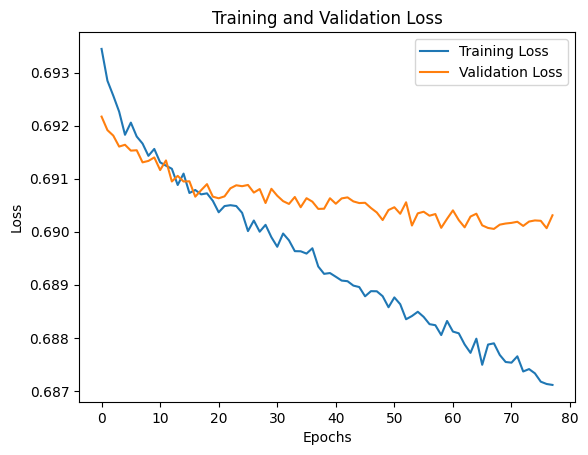

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

# 訓練過程中的損失函數
train_loss = history.history['loss'][5:]
val_loss = history.history['val_loss'][5:]

# 繪製損失函數圖表
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### lightgbm Model

In [35]:
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV

fit_params = {
    "early_stopping_rounds": 30,
    "eval_metric": 'rmse',  # 設置為 RMSE
    "eval_set": [(test[0], test[1])],
    'eval_names': ['valid'],
    'verbose': 100,
    'categorical_feature': 'auto'
}

param_test = {
    'num_leaves': sp_randint(10, 100),
    'min_child_samples': sp_randint(50, 200),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': sp_uniform(loc=0.1, scale=0.9),
    'colsample_bytree': sp_uniform(loc=0.2, scale=0.8),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

# 調整為較小的值，例如100
n_HP_points_to_test = 100

# 將n_estimators設置為10000
clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=10000)

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='neg_mean_squared_error',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True
)


In [36]:
# 替換為實際的訓練數據和適合的參數
gs.fit(*train, **fit_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's rmse: 0.0975891
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's rmse: 0.0975731
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's rmse: 0.0975504
Training until validation scores don't improve for 30 rounds
[100]	valid's rmse: 0.0974903
[200]	valid's rmse: 0.0974869
[300]	valid's rmse: 0.0974864
[400]	valid's rmse: 0.0974864
[500]	valid's rmse: 0.0974864
[600]	valid's rmse: 0.0974864
[700]	valid's rmse: 0.0974864
[800]	valid's rmse: 0.0974864
[900]	valid's rmse: 0.0974864
[1000]	valid's rmse: 0.0974864
[1100]	valid's rmse: 0.0974864
[1200]	valid's rmse: 0.0974864
[1300]	valid's rmse: 0.0974864
Early stopping, best iteration is:
[1343]	valid's rmse: 0.0974864
Training until validation scores don't impro

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(metric='None', n_estimators=10000,
                                           n_jobs=4, random_state=314),
                   n_iter=100,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feec757b450>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feec757b210>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feed32fb090>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
                      

In [37]:
best_params = gs.best_params_
print("Best Parameters:", best_params)
print("----------------")
gs_best_model = lgb.LGBMRegressor(**best_params )
gs_best_model.fit(*train)

Best Parameters: {'colsample_bytree': 0.2034875050003967, 'min_child_samples': 154, 'min_child_weight': 10.0, 'num_leaves': 74, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.5675974263187773}
----------------


LGBMRegressor(colsample_bytree=0.2034875050003967, min_child_samples=154,
              min_child_weight=10.0, num_leaves=74, reg_alpha=0, reg_lambda=5,
              subsample=0.5675974263187773)

#### 結果

In [38]:
print('#Training accuracy {:.4f}'.format(gs_best_model.score(*train)))
print('#Testing accuracy {:.4f}'.format(gs_best_model.score(*test)))

#l1那個
#Training accuracy 0.1127
#Testing accuracy -0.0138

#Training accuracy 0.0581
#Testing accuracy -0.0043

#Training accuracy 0.1361
#Testing accuracy -0.0167



#Training accuracy 0.2266
#Testing accuracy -0.0344


<AxesSubplot:xlabel='Value', ylabel='Feature'>

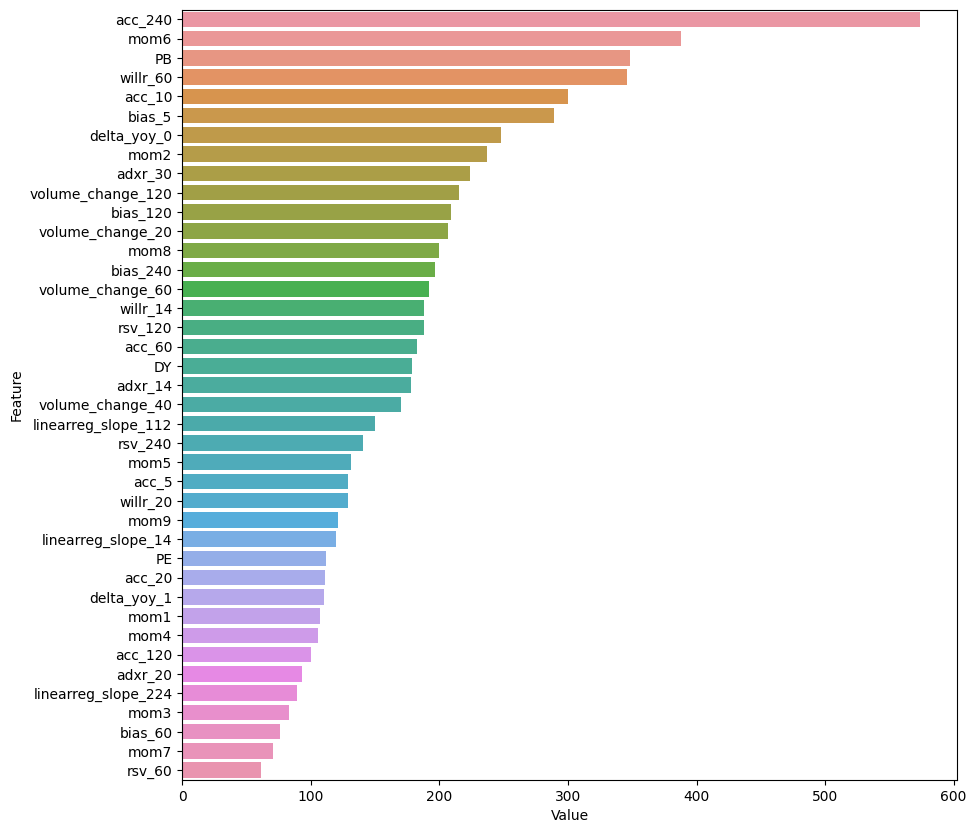

In [39]:
feature_imp = pd.DataFrame(zip(gs_best_model.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp)

### xgboost Model

In [40]:
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

cf_xgb = xgb.XGBRegressor()
cf_xgb.fit(*train)
cf_xgb.score(*test)

-0.14050791095304827

In [41]:
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.model_selection import RandomizedSearchCV

reg = xgb.XGBRegressor()
param_grid = {
    #'silent': [False],
    'max_depth': [6, 10, 15, 20],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'n_estimators': [100]
}
fit_params = {
    'early_stopping_rounds': 10,
    'eval_set': [(test[0], test[1])],
    'verbose': False,
    'eval_metric': 'rmse'
    
}
rs = RandomizedSearchCV(reg, param_grid, n_iter=20, n_jobs=1, verbose=2, cv=2, scoring='neg_mean_squared_error', refit=True, random_state=42)
rs.fit(train[0], train[1], **fit_params)


Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=5.0, n_estimators=100, reg_lambda=50.0, subsample=0.7; total time=   0.7s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=5.0, n_estimators=100, reg_lambda=50.0, subsample=0.7; total time=   0.7s
[CV] END colsample_bylevel=0.9, colsample_bytree=0.7, gamma=1.0, learning_rate=0.01, max_depth=20, min_child_weight=1.0, n_estimators=100, reg_lambda=1.0, subsample=0.6; total time=  10.3s
[CV] END colsample_bylevel=0.9, colsample_bytree=0.7, gamma=1.0, learning_rate=0.01, max_depth=20, min_child_weight=1.0, n_estimators=100, reg_lambda=1.0, subsample=0.6; total time=   9.2s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=15, min_child_weight=7.0, n_estimators=100, reg_lambda=50.0, subsample=0.9; total time=   2.9

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                                              1.0],
                                      

In [42]:
xgb_best_params = rs.best_params_
print("Best Parameters:", xgb_best_params)
print("----------------")
xgb_best_model = xgb.XGBRegressor(**best_params )
xgb_best_model.fit(*train)

Best Parameters: {'subsample': 0.8, 'reg_lambda': 50.0, 'n_estimators': 100, 'min_child_weight': 0.5, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5}
----------------
[19:36:58] WARNING: ../src/learner.cc:627: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.2034875050003967, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_samples=154, min_child_weight=10.0, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_leaves=74, num_parallel_tree=1, predictor='auto',
             random_state=0, ...)

#### 結果

In [43]:
xgb_best_model.score(*test)

-0.10068095675521493

<AxesSubplot:xlabel='Value', ylabel='Feature'>

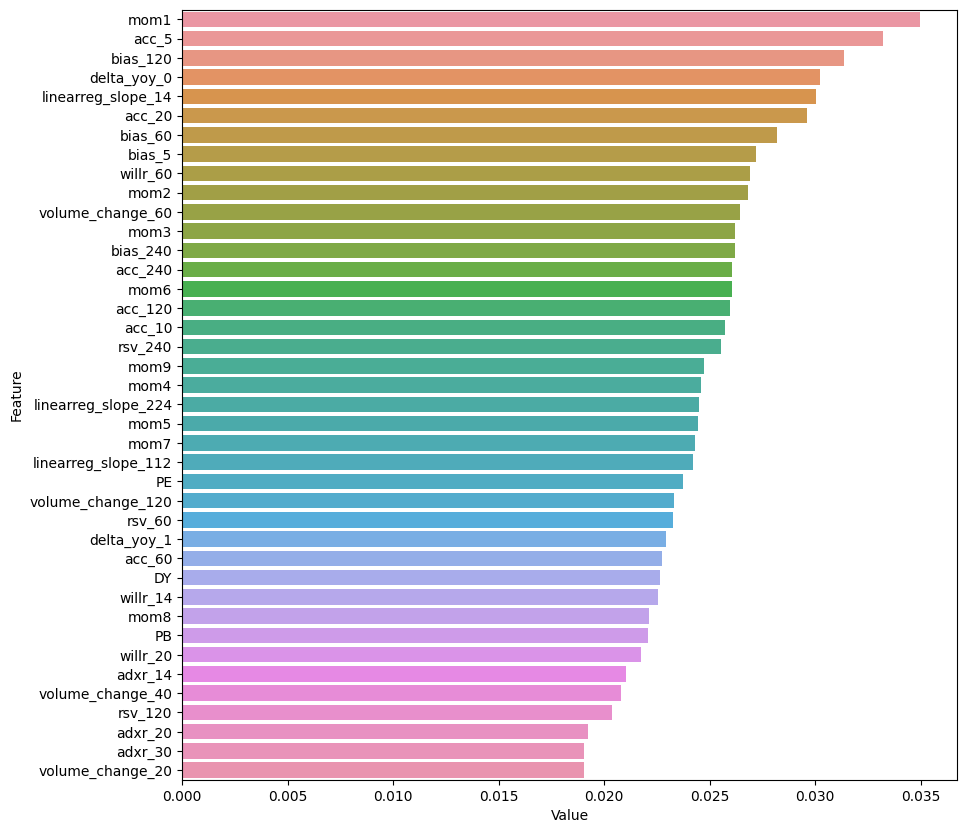

In [44]:
feature_imp = pd.DataFrame(zip(xgb_best_model.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Random Forest Model

In [45]:
#from sklearn.ensemble import RandomForestRegressor
#
#cf2 = RandomForestRegressor(n_estimators=100)
#cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

In [46]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV
#
## 建立隨機森林回歸模型
#cf2 = RandomForestRegressor()
#
## 定義超參數範圍
#param_dist = {
#    'n_estimators': [50, 100, 200, 300],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'bootstrap': [True, False]
#}
#
## 執行隨機參數搜尋
#rs = RandomizedSearchCV(cf2, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42)
#rs.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

在以上程式碼中，我們建立了 RandomForestRegressor 模型，
並定義了超參數的範圍。使用 RandomizedSearchCV 進行參數搜尋，
設定了迭代次數為 100，交叉驗證次數為 5，並設定了 random_state 來保持結果的可重現性。
透過這樣的方式，您可以進一步優化 RandomForestRegressor 模型，以提高其性能。

In [47]:
#feature_imp = pd.DataFrame(zip(cf2.feature_importances_, feature_names), 
#                           columns=['Value','Feature']).sort_values('Value', ascending=False)
#feature_imp
#
#%matplotlib inline
#import seaborn as sns
#plt.figure(figsize=(10,10))
#sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [48]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = gs_best_model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = xgb_best_model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

4565/4565 [==============================] - 3s 701us/step


# backtest

100%|█████████████████████████████████████████| 164/164 [00:09<00:00, 17.07it/s]


<AxesSubplot:xlabel='date'>

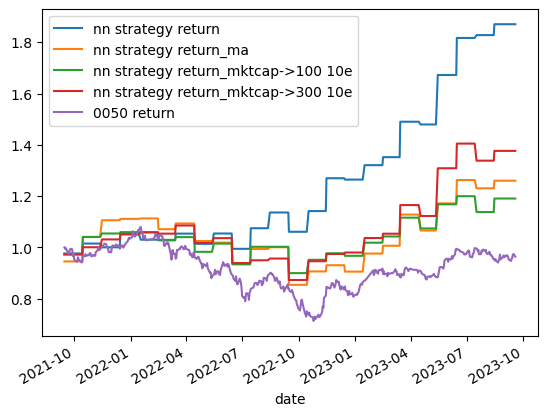

In [49]:
import math
from tqdm import tqdm

dates = sorted(list(set(dataset_drop.index)))
fil_ma_s = 1000  # start
fil_ma_e = 3000  # end

rs_1 = []
rs_2 = []
rs_3 = []  
rs_4 = []  
rs_5 = []  # 收益数据列表

for d in tqdm(dates):
    dataset_time = dataset_drop.loc[d]
    dataset_time = drop_extreme_case(dataset_time, feature_names, thresh=0.01)
    predi_target_0 = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3']
    predi_target_1 = predi_target_0.where((dataset_time['vol_ma5'] > fil_ma_s) & (dataset_time['vol_ma5'] < fil_ma_e) & (dataset_time['市值'] < 1e10), 0)
    predi_target_2 = predi_target_0.where((dataset_time['vol_ma5'] > fil_ma_s) & (dataset_time['市值'] < 1e9), 0)
    predi_target_3 = predi_target_0.where((dataset_time['vol_ma5'] < fil_ma_e) & (dataset_time['市值'] < 1e10), 0)
    predi_target_4 = predi_target_0.where((dataset_time['vol_ma5'] > fil_ma_e) & (dataset_time['市值'] > 1e9), 0)
    
        

    condition_0 = (predi_target_0 >= predi_target_0.nlargest(20).iloc[-1])
    condition_1 = (predi_target_1 >= predi_target_1.nlargest(20).iloc[-1])
    condition_2 = (predi_target_2 >= predi_target_2.nlargest(20).iloc[-1])
    condition_3 = (predi_target_3 >= predi_target_3.nlargest(20).iloc[-1])
    condition_4 = (predi_target_4 >= predi_target_4.nlargest(20).iloc[-1])

    
    r0 = dataset_time['return'][condition_0].mean()
    r1 = dataset_time['return'][condition_1].mean()
    r2 = dataset_time['return'][condition_2].mean()
    r3 = dataset_time['return'][condition_3].mean()
    r4 = dataset_time['return'][condition_4].mean()

    
    rs_1.append(r0 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_2.append(r1 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_3.append(r2 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_4.append(r3 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_5.append(r4 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    

rs_1 = pd.Series(rs_1, index=dates)[Aft:].cumprod()
rs_2 = pd.Series(rs_2, index=dates)[Aft:].cumprod()
rs_3 = pd.Series(rs_3, index=dates)[Aft:].cumprod()
rs_4 = pd.Series(rs_4, index=dates)[Aft:].cumprod()
rs_5 = pd.Series(rs_5, index=dates)[Aft:].cumprod()

s0050 = close['0050'][Aft:]

pd.DataFrame(
    {
        'nn strategy return': rs_1.reindex(s0050.index, method='ffill'),
        'nn strategy return_ma': rs_2.reindex(s0050.index, method='ffill'),
        'nn strategy return_mktcap->100 10e': rs_3.reindex(s0050.index, method='ffill'),
        #'nn strategy return_mktcap-<300 10e': rs_4.reindex(s0050.index, method='ffill'),
        'nn strategy return_mktcap->300 10e': rs_5.reindex(s0050.index, method='ffill'),
        '0050 return': s0050 / s0050[0],
    }
).plot()


In [50]:
    predi_target = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3']
predi_target

date
2023-08-15    2.506219
2023-08-15    2.564431
2023-08-15    2.562026
2023-08-15    2.557946
2023-08-15    2.658335
                ...   
2023-08-15    2.570669
2023-08-15    2.482870
2023-08-15    2.465655
2023-08-15    2.579708
2023-08-15    2.556623
Length: 748, dtype: float64

### 當月持股狀況

In [51]:
dataset.index.levels[1].max()

Timestamp('2023-09-15 00:00:00')

25/25 [==============================] - 0s 808us/step


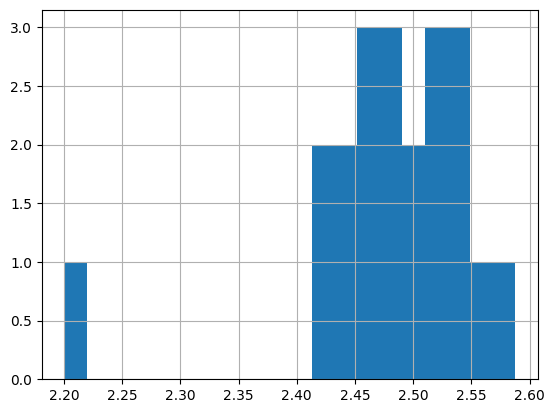

In [52]:
# get the latest dataset
last_date = dataset.index.levels[1].max()#"2022-10-15"
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset,
                                 feature_names, thresh=0.01)


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = gs_best_model.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = xgb_best_model.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
#rank_target = rank.where((last_dataset['vol_ma5'] > fil_ma_s)  & (last_dataset['vol_ma5'] < fil_ma_e)  & (last_dataset['市值'] < 1e10), 0)
rank_target = rank.where((last_dataset['vol_ma5'] > fil_ma_e)  & (last_dataset['市值'] < 1e10), 0)

condition = (rank_target >= rank_target.nlargest(20).iloc[-1]) 

# plot rank distribution
rank_target[rank_target != 0].hist(bins=20)


# show the best 20 stocks
slist1 = rank_target[rank_target != 0].reset_index()['stock_id']

In [53]:
#rank_target['8299']

# 平均分配資產於股票之中

In [54]:
close = data.get("收盤價")

money = 626732
stock_prices = close[rank_target[condition].reset_index()['stock_id']].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000


股票平分張數:


stock_id
1217    2.516996
1524    1.238601
1584    0.924383
1618    1.107300
1737    0.941039
2316    0.835643
2405    1.977073
2425    0.667446
2427    1.173655
3025    0.732164
3046    0.426348
3071    0.832313
3094    0.904375
3338    0.498197
4916    0.799403
5225    0.569756
5284    0.230416
6167    1.904960
6170    0.552674
8088    0.838999
Name: 2023-09-18 00:00:00, dtype: float64

In [55]:
T_stock = '1101'
(last_dataset['vol_ma5'][T_stock] > fil_ma_s)
(last_dataset['vol_ma5'][T_stock] < fil_ma_e)  & (last_dataset['市值'] < 1e10)

stock_id  date      
1101      2023-09-15    False
1102      2023-09-15    False
1103      2023-09-15    False
1108      2023-09-15    False
1109      2023-09-15    False
                        ...  
9939      2023-09-15    False
9940      2023-09-15    False
9941      2023-09-15    False
9951      2023-09-15    False
9962      2023-09-15    False
Length: 788, dtype: bool

In [56]:
import pyfolio as pf

import pickle
pickle.dump(rs_2, open('230618_return_history.pkl', 'wb'))

In [57]:
 rs_2

2021-09-15    0.945184
2021-10-15    1.040581
2021-11-15    1.105843
2021-12-15    1.111187
2022-01-15    1.112898
2022-02-15    1.071027
2022-03-15    1.093354
2022-04-15    1.024928
2022-05-15    1.018600
2022-06-15    0.937395
2022-07-15    0.993841
2022-08-15    1.000632
2022-09-15    0.853985
2022-10-15    0.906335
2022-11-15    0.930443
2022-12-15    0.905583
2023-01-15    0.976032
2023-02-15    1.006355
2023-03-15    1.127892
2023-04-15    1.065790
2023-05-15    1.171593
2023-06-15    1.262581
2023-07-15    1.230355
2023-08-15    1.260013
dtype: float64

In [58]:
pf.tears.create_capacity_tear_sheet(rs_2)

TypeError: create_capacity_tear_sheet() missing 3 required positional arguments: 'positions', 'transactions', and 'market_data'

In [ ]:
import pickle
import pandas as pd

# 得到 上面的 回測結果
ret = pickle.load(open("230618_return_history.pkl", "rb"))

# 將回測報酬率取出來
ret = ret.pct_change().dropna()
#ret.index = pd.to_datetime(ret.index).tz_localize('Asia/Taipei')

# 利用pyfolio 比較報酬率

pf.create_returns_tear_sheet(ret, benchmark_rets=close['0050'].reindex(ret.index, method='ffill').pct_change())

###################################################################################################
## 移動窗格最佳化
[有空來試試看連結](https://hahow.in/courses/5b9d3a6dca498a001e917383/discussions/61b4c90147843d0006cf2593)

###################################################################################################

In [ ]:
train = dataset_train[feature_names].astype(float) , dataset_train['return'] #> 1.00
test = dataset_test[feature_names].astype(float) , dataset_test['return'] #> 1.00

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 創建Random Forest模型
random_forest = RandomForestRegressor(n_estimators=100)

# 使用訓練資料訓練模型
random_forest.fit(*train)

# 使用測試資料評估模型
accuracy = random_forest.score(*test)
print("Random Forest 模型的準確率：", accuracy)

In [ ]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import numpy as np

%matplotlib inline

def select(df):

    rank = df['pre']

    condition1 = (rank >= rank.nlargest(1).iloc[-1])

    return df['return'][condition1].mean() * (1-3/1000-1.425/1000*2*0.6)

end = 5

cf = lgb.LGBMRegressor(n_estimators=500)



train_time = ['2015','2016','2017','2018','2019']

s_time = ['2007','2008','2009','2010','2011']

test_time = ['2016','2017','2018','2019','2020']

dataset_copy = dataset_dropna.copy()

store_mse = []

In [ ]:
for time in range(end):

    print('%d 次執行中'%(time+1))

    dataset_dropna2_train = dataset_copy.loc[s_time[time]:train_time[time]] #2007~ 2015   2008~2016   2009~2017  2010~2018  ....

    dataset_dropna2_test = dataset_copy.loc[test_time[time]:test_time[time]]#            2016                2017               2018              2019  .....

    
    cf.fit(dataset_dropna2_train[feature_names].astype(float), dataset_dropna2_train['rank'])
    predict = cf.predict(dataset_dropna2_test[feature_names])

    dataset_dropna2_test['pre'] = predict

    dates = dataset_dropna2_test.index.get_level_values('date')
    
    b = dataset_dropna2_test.groupby(dates).apply(select).cumprod()
    
    s0050 = close['0050'][test_time[time]:test_time[time]]
    
    s0056 = close['0056'][test_time[time]:test_time[time]]
    
    pd.DataFrame({'Best 1 stocks return(include handling fee)':b.reindex(s0050.index, method='ffill'), 
    
                  '0050':s0050/s0050[0],'0056':s0056/s0056[0]}).plot()
    
    plt.ylabel('return')



In [ ]:
cf.predict(dataset_dropna2_test[feature_names])

In [ ]:
dataset_dropna2_train[feature_names].astype(float)